In [1]:
import os
from keras.datasets import mnist
import random 
from matplotlib import pyplot as plt
import numpy as np
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Softmax, Multiply
import tensorflow as tf

In [2]:
#load the data from the mnist dataset
(train_img, train_label), (test_img, test_label) = mnist.load_data()

In [3]:
# Combine the features and labels for shuffling
train_data = list(zip(train_img, train_label))

# Shuffle the training data
np.random.shuffle(train_data)

# Unzip the shuffled data back into separate arrays for features and labels
train_img, train_label = zip(*train_data)

# Convert back to numpy arrays if needed
train_img = np.array(train_img)
train_label = np.array(train_label)

In [4]:
#split training data into train and validation sets
val_split = 1/6
val_size = int(val_split * len(train_img))

val_img = train_img[:val_size]
val_label = train_label[:val_size]

train_img = train_img[val_size:]
train_label = train_label[val_size:]

In [5]:
#normalize pixel values to range [0, 1]
train_img = train_img / 255.0
test_img = test_img / 255.0
val_img = val_img / 255.0

In [6]:
#visualize size of data sets
print(train_img.shape)
print(test_img.shape)
print(val_img.shape)
print(train_label.shape)
print(test_label.shape)
print(val_label.shape)

(50000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)
(50000,)
(10000,)
(10000,)


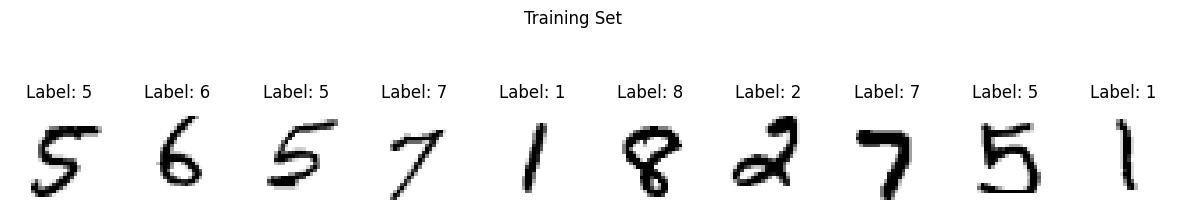

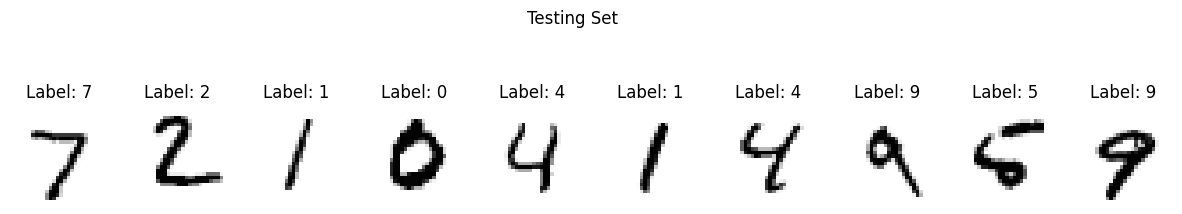

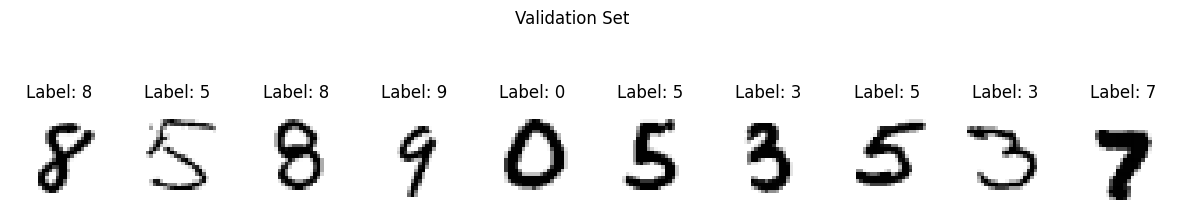

In [7]:
#visualize 10 images and their labels from each set
def plot_images(images, labels, title):
    plt.figure(figsize=(15, 3))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plot images and labels from the training set
plot_images(train_img[:10], train_label[:10], "Training Set")

# Plot images and labels from the testing set
plot_images(test_img[:10], test_label[:10], "Testing Set")

# Plot images and labels from the testing set
plot_images(val_img[:10], val_label[:10], "Validation Set")

In [8]:
#one-hot ecode labels
train_label=to_categorical(train_label)
test_label=to_categorical(test_label)
val_label=to_categorical(val_label)

In [9]:
# Define the custom attention layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.filters = input_shape[3]
        self.W = self.add_weight(name='attention_W', shape=(1, 1, self.filters, self.filters), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name='attention_b', shape=(self.filters,), initializer="zeros", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        attention_weights = tf.nn.tanh(tf.nn.conv2d(inputs, self.W, strides=[1, 1, 1, 1], padding="SAME") + self.b)
        attention_weights = Softmax(axis=-1)(attention_weights)
        attended_inputs = Multiply()([inputs, attention_weights])
        return attended_inputs

# Define the model architecture with attention mechanism using Sequential API
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    AttentionLayer(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(units=10, activation='softmax')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 attention_layer (AttentionL  (None, 5, 5, 64)         4160      
 ayer)                                                           
                                                        

In [10]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_img, train_label, epochs=9, batch_size=256, validation_data=(test_img, test_label))

Epoch 1/9
196/196 [==============================] - 18s 88ms/step - loss: 0.6951 - acc: 0.8037 - val_loss: 0.1389 - val_acc: 0.9585
Epoch 2/9
196/196 [==============================] - 17s 87ms/step - loss: 0.1337 - acc: 0.9605 - val_loss: 0.0855 - val_acc: 0.9738
Epoch 3/9
196/196 [==============================] - 17s 88ms/step - loss: 0.0953 - acc: 0.9706 - val_loss: 0.0667 - val_acc: 0.9776
Epoch 4/9
196/196 [==============================] - 17s 85ms/step - loss: 0.0776 - acc: 0.9764 - val_loss: 0.0514 - val_acc: 0.9833
Epoch 5/9
196/196 [==============================] - 17s 87ms/step - loss: 0.0660 - acc: 0.9797 - val_loss: 0.0462 - val_acc: 0.9836
Epoch 6/9
196/196 [==============================] - 17s 86ms/step - loss: 0.0588 - acc: 0.9815 - val_loss: 0.0435 - val_acc: 0.9853
Epoch 7/9
196/196 [==============================] - 17s 86ms/step - loss: 0.0501 - acc: 0.9844 - val_loss: 0.0435 - val_acc: 0.9848
Epoch 8/9
196/196 [==============================] - 17s 87ms/step - 

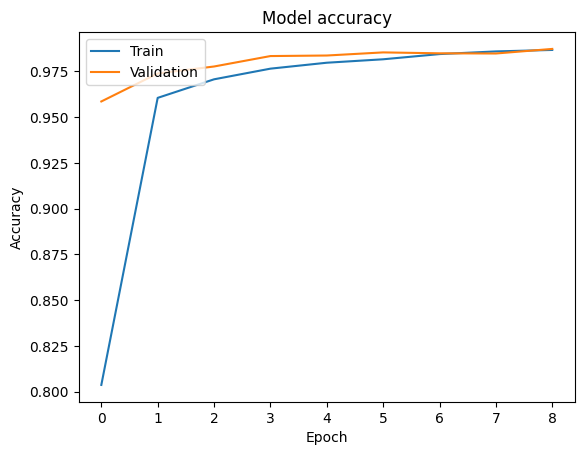

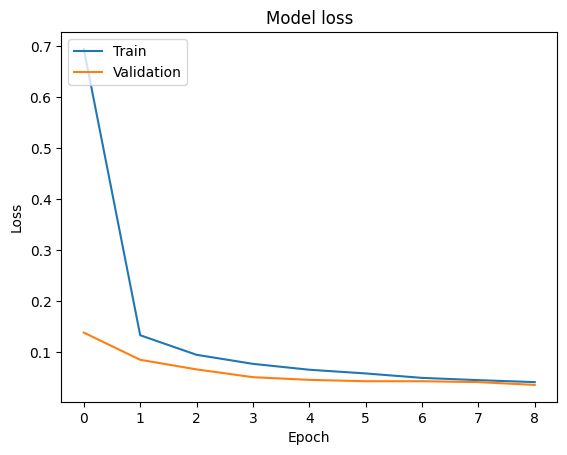

In [11]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
# Save the model
model = model.save("attention_mechanism_model.h5") 

In [13]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [14]:
# Load the saved model
loaded_model = load_model("mnist_model.h5", custom_objects={'AttentionLayer': AttentionLayer})

In [15]:
# Evaluate the model on the validation set
val_loss, val_acc = loaded_model.evaluate(val_img, val_label)
print(f"Validation Accuracy: {val_acc}")

313/313 [==============================] - 2s 4ms/step - loss: 0.0118 - acc: 0.9974
Validation Accuracy: 0.9973999857902527


1/1 [==============================] - 0s 125ms/step


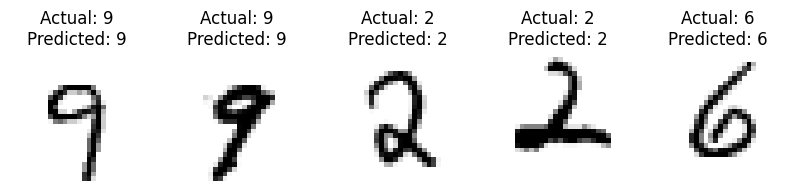

In [16]:
# Choose random indices from the validation set
num_examples = 5
random_indices = np.random.choice(val_img.shape[0], num_examples)

# Predict labels for the chosen examples
predicted_labels = loaded_model.predict(val_img[random_indices])
predicted_classes = np.argmax(predicted_labels, axis=1)

# Plot the examples
plt.figure(figsize=(10, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(val_img[idx].reshape(28, 28), cmap=plt.cm.binary)
    plt.title(f"Actual: {np.argmax(val_label[idx])}\nPredicted: {predicted_classes[i]}")
    plt.axis('off')
plt.show()


In [17]:
# Predict labels for all examples in the validation set
predicted_labels_all = loaded_model.predict(val_img)
predicted_classes_all = np.argmax(predicted_labels_all, axis=1)

# Convert one-hot encoded labels back to integers
true_classes_all = np.argmax(val_label, axis=1)

313/313 [==============================] - 2s 6ms/step


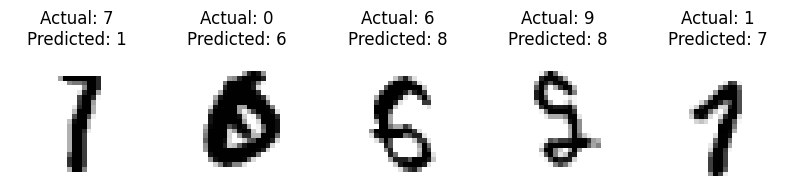

In [24]:
# Find indices of incorrectly classified examples
incorrect_indices = np.where(predicted_classes_all != true_classes_all)[0]

# Choose random incorrect indices
num_incorrect_examples = 5
random_incorrect_indices = np.random.choice(incorrect_indices, num_incorrect_examples)

# Plot incorrect examples
plt.figure(figsize=(10, 5))
for i, idx in enumerate(random_incorrect_indices):
    plt.subplot(1, num_incorrect_examples, i + 1)
    plt.imshow(val_img[idx].reshape(28, 28), cmap=plt.cm.binary)
    plt.title(f"Actual: {true_classes_all[idx]}\nPredicted: {predicted_classes_all[idx]}")
    plt.axis('off')
plt.show()

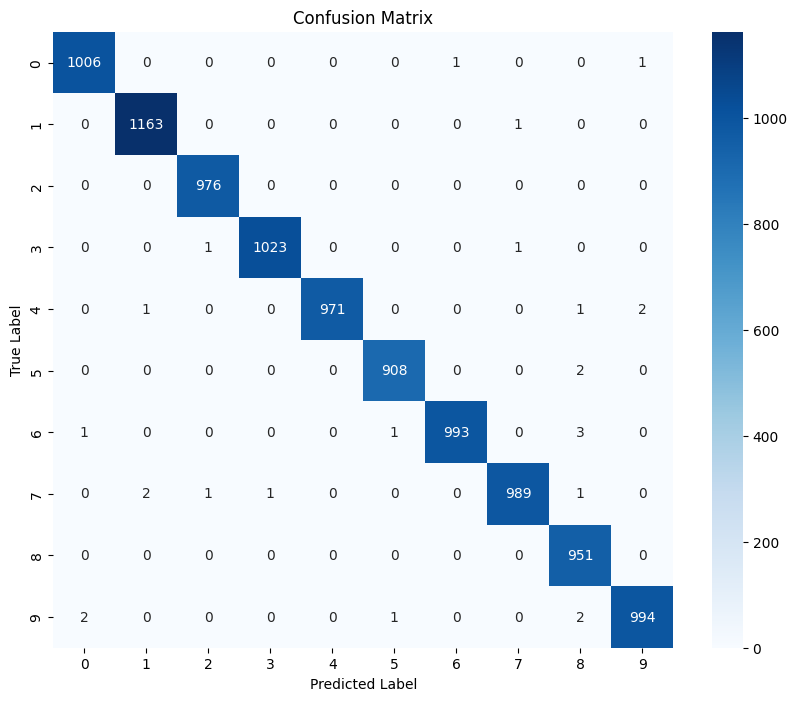

In [19]:
# Create confusion matrix
conf_matrix = confusion_matrix(true_classes_all, predicted_classes_all)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
